In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

from hashlib import sha256
from random import sample, randint
from json import dump
from copy import deepcopy

# Read datasets

In [2]:
articles_review = pd.read_csv('./datasets inputs/rating.csv', names=['CONTENT_ID', 'MEMBER_ID', 'RATING', '1', '2', '3', '4', '5'], delimiter=',', dtype=object)
member_content = pd.read_csv('./datasets inputs/member_content.csv', names=['CONTENT_ID', 'AUTHOR_ID', 'SUBJECT'], delimiter=',', dtype=object)
user_rating = pd.read_csv('./datasets inputs/user_rating.csv', names=['MY_ID', 'OTHER_ID', 'VALUE', 'CREATION'], delimiter=',', dtype=object)

In [3]:
articles_review

,CONTENT_ID,MEMBER_ID,RATING,1,2,3,4,5
0,139431556,1312460676,5,0,2001/01/10,NaN,1,2518365.0
1,139431556,204358,5,0,2001/01/10,NaN,1,2518365.0
2,139431556,368725,5,0,2001/01/10,NaN,1,2518365.0
3,139431556,277629,5,0,2001/01/10,NaN,1,2518365.0
4,139431556,246386,5,0,2001/01/10,NaN,1,2518365.0
...,...,...,...,...,...,...,...,...
13668314,891503,311238,5,0,2001/01/10,2001/12/27,1,2522499.0
13668315,891503,210412,5,0,2001/01/10,2001/12/27,1,2522499.0
13668316,891503,351471,5,0,2001/01/10,2001/12/27,1,2522499.0
13668317,891503,394639,5,0,2001/01/10,2001/12/27,1,2522499.0


In [4]:
articles_review.drop(['1', '2', '3', '4', '5'], axis=1, inplace=True)

In [5]:
member_content

,CONTENT_ID,AUTHOR_ID,SUBJECT
0,1445595,220568,149003604865
1,1445596,717325,5303145344
2,1445597,360156,192620893057
3,1445598,718857,149002163073
4,1445600,513114,34252
...,...,...,...
1560138,113644637827,478558,226947339137
1560139,113644703363,478558,579633517441
1560140,113644768899,478558,262002480001
1560141,113644834435,478558,332026254209


In [6]:
user_rating

,MY_ID,OTHER_ID,VALUE,CREATION
0,3288305540,709420,1,2001/01/10
1,3290337156,204418,-1,2001/01/10
2,3294138244,269243,-1,2001/01/10
3,3294138244,170692484,-1,2001/01/10
4,3296759684,347967364,1,2001/01/10
...,...,...,...,...
841366,377602,75017588612,1,2003/08/12
841367,83329126276,203962,1,2003/08/12
841368,79757938564,1955106692,1,2003/08/12
841369,66846035844,399055,1,2003/08/12


In [7]:
user_rating.drop(['CREATION'], axis=1, inplace=True)

# Creating contexts layer

In [8]:
context_layer_edges = pd.merge(articles_review, member_content, on='CONTENT_ID')
context_layer_edges['RATING'] = context_layer_edges['RATING'].astype(int)
context_layer_edges.loc[context_layer_edges['RATING'] == 6, ['RATING']] = 5
context_layer_edges['RATING'] = context_layer_edges['RATING'].apply(lambda v: (v / 10) * 2)
context_layer_edges.drop('CONTENT_ID', axis=1, inplace=True)
context_layer_edges

,MEMBER_ID,RATING,AUTHOR_ID,SUBJECT
0,1312460676,1.0,2252443524,33578
1,204358,1.0,2252443524,33578
2,368725,1.0,2252443524,33578
3,277629,1.0,2252443524,33578
4,246386,1.0,2252443524,33578
...,...,...,...,...
13668098,311238,1.0,342187,342306558849
13668099,210412,1.0,342187,342306558849
13668100,351471,1.0,342187,342306558849
13668101,394639,1.0,342187,342306558849


In [9]:
context_layer_edges.groupby(by=['SUBJECT']).size().sort_values(ascending=False)[:4000]

SUBJECT
6854272         244019
526227072       169371
462395008       131747
149004129153     78554
7640704          60366
                 ...  
45504              529
4588344192         529
4522873728         529
164524             529
140498             529
Length: 4000, dtype: int64

In [10]:
context_layer_edges.drop(context_layer_edges[(context_layer_edges.SUBJECT != "45504")].index, inplace=True)
context_layer_edges.reset_index(drop=True, inplace=True)

In [11]:
context_layer_edges

,MEMBER_ID,RATING,AUTHOR_ID,SUBJECT
0,235766,1.0,386469,45504
1,408577,1.0,386469,45504
2,332346,1.0,386469,45504
3,655625,1.0,386469,45504
4,406573,1.0,386469,45504
...,...,...,...,...
524,210284,1.0,280653,45504
525,234885,1.0,280653,45504
526,363231,1.0,280653,45504
527,216022,1.0,280653,45504


In [12]:
context_layer_edges.groupby(by=['RATING']).size().sort_values(ascending=False)

RATING
1.0    458
0.8     54
0.6     10
0.4      7
dtype: int64

In [13]:
nodes = pd.DataFrame(columns=['ID'])
nodes['ID'] = pd.concat([context_layer_edges['MEMBER_ID'], context_layer_edges['AUTHOR_ID']], ignore_index=True)
nodes.drop_duplicates(inplace=True, ignore_index=True)
nodes

,ID
0,235766
1,408577
2,332346
3,655625
4,406573
...,...
403,1008766852
404,592568
405,526497
406,208802


# Creating issuers layer

In [14]:
user_rating['VALUE'] = user_rating['VALUE'].astype(int)
user_rating.loc[user_rating['VALUE'] < 0, ['VALUE']] = 0
user_rating

,MY_ID,OTHER_ID,VALUE
0,3288305540,709420,1
1,3290337156,204418,0
2,3294138244,269243,0
3,3294138244,170692484,0
4,3296759684,347967364,1
...,...,...,...
841366,377602,75017588612,1
841367,83329126276,203962,1
841368,79757938564,1955106692,1
841369,66846035844,399055,1


In [15]:
issuers = pd.DataFrame(columns=['ID'])
issuers['ID'] = context_layer_edges['AUTHOR_ID']
issuers.drop_duplicates(inplace=True, ignore_index=True)
issuers

,ID
0,386469
1,504747
2,337335
3,32205279108
4,235544
5,305079
6,548953
7,281312
8,270405
9,436854


In [16]:
issuer_layer_edges = user_rating.copy()
# get only edges between issuers
issuer_layer_edges = issuer_layer_edges[issuer_layer_edges['MY_ID'].isin(issuers['ID'])]
issuer_layer_edges = issuer_layer_edges[issuer_layer_edges['OTHER_ID'].isin(issuers['ID'])]
issuer_layer_edges.reset_index(drop=True, inplace=True)
issuer_layer_edges

,MY_ID,OTHER_ID,VALUE
0,280653,281312,1
1,280653,305079,0
2,281312,280653,1
3,386469,504747,1
4,548953,504747,1
5,504747,386469,1
6,504747,216022,1
7,504747,548953,1
8,305079,280653,0
9,216022,305079,0


# Creating entrypoints layer

In [17]:
entrypoints_edges = user_rating.copy()
# get only edges between a generic node and an issuer
entrypoints_edges = entrypoints_edges[entrypoints_edges['MY_ID'].isin(nodes['ID'])]
entrypoints_edges = entrypoints_edges[entrypoints_edges['OTHER_ID'].isin(issuers['ID'])]
entrypoints_edges.reset_index(drop=True, inplace=True)
entrypoints_edges

,MY_ID,OTHER_ID,VALUE
0,231243,337335,1
1,242030,337335,1
2,246386,216022,1
3,261899,216022,1
4,239232,216022,1
...,...,...,...
440,372200,1008766852,1
441,202028,526497,1
442,667808,1008766852,1
443,10286567300,1008766852,1


# Creating DIDs

In [18]:
nodes = nodes.applymap(lambda v: 'did:indy:' + sha256(('GENERIC-' + v).encode('utf-8')).hexdigest()[:16])
nodes

,ID
0,did:indy:fc455279f4610052
1,did:indy:058e845e604ca666
2,did:indy:7ced776a82263470
3,did:indy:65dd2c7340078a75
4,did:indy:b940326bb9496a1f
...,...
403,did:indy:50bc909a9737bdf8
404,did:indy:22221630f303d121
405,did:indy:8d9c55b0a9227cbe
406,did:indy:438b3ec03977a9d8


In [19]:
issuers = issuers.applymap(lambda v: 'did:indy:' + sha256(('ISSUERS-' + v).encode('utf-8')).hexdigest()[:16])
issuers

,ID
0,did:indy:d29cbe66d6ec3edd
1,did:indy:5c2803deafdfbc06
2,did:indy:0498be39b559ff7b
3,did:indy:c9eca6671495a433
4,did:indy:2a63dc38cc2caa83
5,did:indy:801bff4662e9a9cd
6,did:indy:e71ea3c452f10fb9
7,did:indy:6536dec2e7de4e60
8,did:indy:fa8c6c20bb22d619
9,did:indy:e504157478e9a4e7


In [20]:
issuer_layer_edges['MY_ID'] = issuer_layer_edges['MY_ID'].apply(lambda v: 'did:indy:' + sha256(('ISSUERS-' + v).encode('utf-8')).hexdigest()[:16])
issuer_layer_edges['OTHER_ID'] = issuer_layer_edges['OTHER_ID'].apply(lambda v: 'did:indy:' + sha256(('ISSUERS-' + v).encode('utf-8')).hexdigest()[:16])
issuer_layer_edges

,MY_ID,OTHER_ID,VALUE
0,did:indy:239579ddadd00f86,did:indy:6536dec2e7de4e60,1
1,did:indy:239579ddadd00f86,did:indy:801bff4662e9a9cd,0
2,did:indy:6536dec2e7de4e60,did:indy:239579ddadd00f86,1
3,did:indy:d29cbe66d6ec3edd,did:indy:5c2803deafdfbc06,1
4,did:indy:e71ea3c452f10fb9,did:indy:5c2803deafdfbc06,1
5,did:indy:5c2803deafdfbc06,did:indy:d29cbe66d6ec3edd,1
6,did:indy:5c2803deafdfbc06,did:indy:9f7d360e01593e9c,1
7,did:indy:5c2803deafdfbc06,did:indy:e71ea3c452f10fb9,1
8,did:indy:801bff4662e9a9cd,did:indy:239579ddadd00f86,0
9,did:indy:9f7d360e01593e9c,did:indy:801bff4662e9a9cd,0


In [21]:
context_layer_edges['MEMBER_ID'] = context_layer_edges['MEMBER_ID'].apply(lambda v: 'did:indy:' + sha256(('GENERIC-' + v).encode('utf-8')).hexdigest()[:16])
context_layer_edges['AUTHOR_ID'] = context_layer_edges['AUTHOR_ID'].apply(lambda v: 'did:indy:' + sha256(('GENERIC-' + v).encode('utf-8')).hexdigest()[:16])
context_layer_edges

,MEMBER_ID,RATING,AUTHOR_ID,SUBJECT
0,did:indy:fc455279f4610052,1.0,did:indy:ed0ff115ffb8d419,45504
1,did:indy:058e845e604ca666,1.0,did:indy:ed0ff115ffb8d419,45504
2,did:indy:7ced776a82263470,1.0,did:indy:ed0ff115ffb8d419,45504
3,did:indy:65dd2c7340078a75,1.0,did:indy:ed0ff115ffb8d419,45504
4,did:indy:b940326bb9496a1f,1.0,did:indy:ed0ff115ffb8d419,45504
...,...,...,...,...
524,did:indy:182c136a6d753541,1.0,did:indy:337a681e46d7c4b8,45504
525,did:indy:50305d98c72cb965,1.0,did:indy:337a681e46d7c4b8,45504
526,did:indy:f760553a11f26739,1.0,did:indy:337a681e46d7c4b8,45504
527,did:indy:0b655011ee641039,1.0,did:indy:337a681e46d7c4b8,45504


In [22]:
entrypoints_edges['MY_ID'] = entrypoints_edges['MY_ID'].apply(lambda v: 'did:indy:' + sha256(('GENERIC-' + v).encode('utf-8')).hexdigest()[:16])
entrypoints_edges['OTHER_ID'] = entrypoints_edges['OTHER_ID'].apply(lambda v: 'did:indy:' + sha256(('ISSUERS-' + v).encode('utf-8')).hexdigest()[:16])
entrypoints_edges

,MY_ID,OTHER_ID,VALUE
0,did:indy:c6ec16df69c025ff,did:indy:0498be39b559ff7b,1
1,did:indy:d15ce73d27e28cdd,did:indy:0498be39b559ff7b,1
2,did:indy:525f0493ccfacfda,did:indy:9f7d360e01593e9c,1
3,did:indy:0107a26937094567,did:indy:9f7d360e01593e9c,1
4,did:indy:d5a4e9794b99cb69,did:indy:9f7d360e01593e9c,1
...,...,...,...
440,did:indy:3db8b53c8ea8bd1a,did:indy:677fb496d29b0648,1
441,did:indy:18dc8c9ebf333ea2,did:indy:50186291f0a55ae3,1
442,did:indy:fe903b390c4b4d84,did:indy:677fb496d29b0648,1
443,did:indy:7fa1a9bdf2541812,did:indy:677fb496d29b0648,1


# Graph analysis

## Issuers graph

In [23]:
issuers_graph = nx.from_pandas_edgelist(issuer_layer_edges, source='MY_ID', target='OTHER_ID',
                                        edge_attr='VALUE', create_using=nx.DiGraph())

In [24]:
in_degree_sequence_issuers = sorted(((n,d) for n, d in issuers_graph.in_degree()), reverse=True, key=lambda tup: tup[1])
in_degree_sequence_issuers[:15]

[('did:indy:239579ddadd00f86', 2),
 ('did:indy:801bff4662e9a9cd', 2),
 ('did:indy:5c2803deafdfbc06', 2),
 ('did:indy:677fb496d29b0648', 2),
 ('did:indy:f2c4d7de9d8556e8', 2),
 ('did:indy:6536dec2e7de4e60', 1),
 ('did:indy:d29cbe66d6ec3edd', 1),
 ('did:indy:e71ea3c452f10fb9', 1),
 ('did:indy:9f7d360e01593e9c', 1),
 ('did:indy:0498be39b559ff7b', 1),
 ('did:indy:2a63dc38cc2caa83', 1),
 ('did:indy:50186291f0a55ae3', 1)]

In [25]:
list(filter(lambda t: t[1] >= 1, in_degree_sequence_issuers))[-15:]

[('did:indy:239579ddadd00f86', 2),
 ('did:indy:801bff4662e9a9cd', 2),
 ('did:indy:5c2803deafdfbc06', 2),
 ('did:indy:677fb496d29b0648', 2),
 ('did:indy:f2c4d7de9d8556e8', 2),
 ('did:indy:6536dec2e7de4e60', 1),
 ('did:indy:d29cbe66d6ec3edd', 1),
 ('did:indy:e71ea3c452f10fb9', 1),
 ('did:indy:9f7d360e01593e9c', 1),
 ('did:indy:0498be39b559ff7b', 1),
 ('did:indy:2a63dc38cc2caa83', 1),
 ('did:indy:50186291f0a55ae3', 1)]

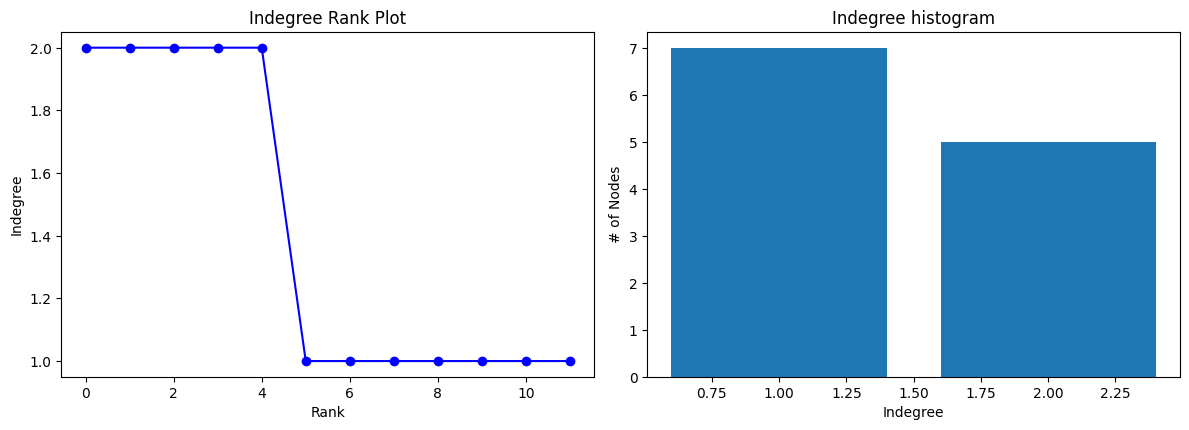

In [26]:
fig = plt.figure(figsize=(12, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(4, 4)
in_degree = sorted((d for n, d in issuers_graph.in_degree()), reverse=True)
"""
ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc_issuers = issuers_graph.subgraph(sorted(nx.strongly_connected_components(issuers_graph), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc_issuers, seed=10396953)
nx.draw_networkx_nodes(Gcc_issuers, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc_issuers, pos, ax=ax0, alpha=0.4)
ax0.set_title("Strongly connected components of G")
ax0.set_axis_off()"""

ax1 = fig.add_subplot(axgrid[2:, :2])
ax1.plot(in_degree, "b-", marker="o")
ax1.set_title("Indegree Rank Plot")
ax1.set_ylabel("Indegree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[2:, 2:])
ax2.bar(*np.unique(in_degree, return_counts=True))
ax2.set_title("Indegree histogram")
ax2.set_xlabel("Indegree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

## Contexts graph

In [27]:
contexts_graph = nx.from_pandas_edgelist(context_layer_edges, source='MEMBER_ID', target='AUTHOR_ID',
                                       edge_attr='RATING', create_using=nx.DiGraph())

In [28]:
out_degree_sequence_contexts = sorted(((n,d) for n, d in contexts_graph.out_degree()), reverse=True, key=lambda tup: tup[1])
out_degree_sequence_contexts[:15]

[('did:indy:c22752f3419b9e7d', 6),
 ('did:indy:8b10118866c3bd67', 6),
 ('did:indy:3a99367f623d136b', 5),
 ('did:indy:182c136a6d753541', 5),
 ('did:indy:3e114e8aafb1ba3a', 4),
 ('did:indy:5364a893aa30076f', 4),
 ('did:indy:4b947bc9ccfc568d', 4),
 ('did:indy:9fe71b6dcf44732d', 4),
 ('did:indy:c7b6378f76a3b144', 3),
 ('did:indy:93ebba30b93bc78a', 3),
 ('did:indy:242a01a06261db4e', 3),
 ('did:indy:cc4995885c596ff7', 3),
 ('did:indy:9d765bb82d69fa20', 3),
 ('did:indy:bc1ee56a3e76d4c0', 3),
 ('did:indy:e8dd145153707fe7', 3)]

In [29]:
list(filter(lambda t: t[1] >= 1, out_degree_sequence_contexts))[-15:]

[('did:indy:5303d50e026f63f9', 1),
 ('did:indy:9953300451f305e3', 1),
 ('did:indy:bc3a7fda86e82d62', 1),
 ('did:indy:a4bc31f4b7e0d64d', 1),
 ('did:indy:5e289795960f00ab', 1),
 ('did:indy:5e62d99f0aacd03a', 1),
 ('did:indy:5e018f32c62e9519', 1),
 ('did:indy:7422ff8de00440be', 1),
 ('did:indy:e4cd9218688c077b', 1),
 ('did:indy:868426a7b404a27c', 1),
 ('did:indy:c749e9a9de6c5e1e', 1),
 ('did:indy:269c795b0644f7d7', 1),
 ('did:indy:525f0493ccfacfda', 1),
 ('did:indy:ee31589059ac8b64', 1),
 ('did:indy:50305d98c72cb965', 1)]

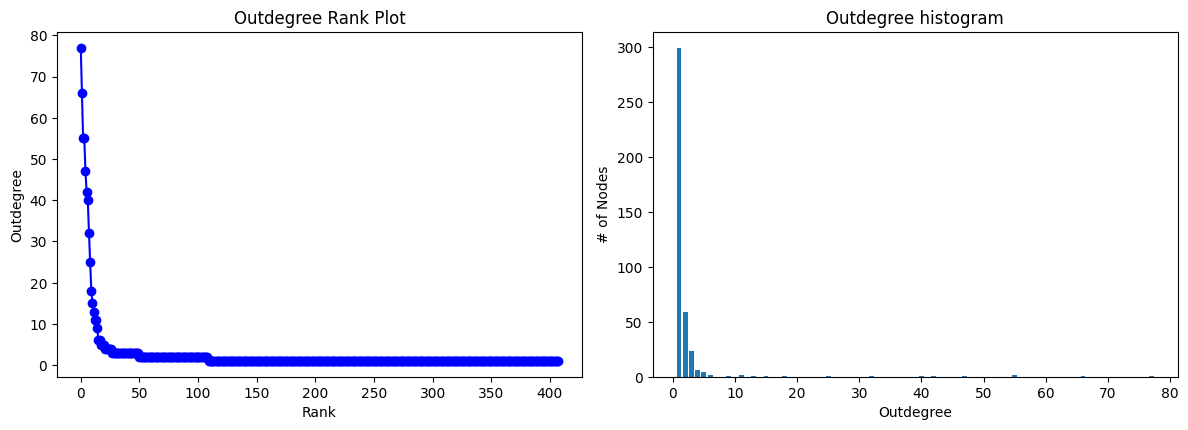

In [30]:
fig = plt.figure(figsize=(12, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(4, 4)
degree = sorted((d for n, d in contexts_graph.degree()), reverse=True)
"""
ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc_contexts = contexts_graph.subgraph(sorted(nx.strongly_connected_components(issuers_graph), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc_contexts, seed=10396953)
nx.draw_networkx_nodes(Gcc_contexts, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc_contexts, pos, ax=ax0, alpha=0.4)
ax0.set_title("Strongly connected components of G")
ax0.set_axis_off()"""

ax1 = fig.add_subplot(axgrid[2:, :2])
ax1.plot(degree, "b-", marker="o")
ax1.set_title("Outdegree Rank Plot")
ax1.set_ylabel("Outdegree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[2:, 2:])
ax2.bar(*np.unique(degree, return_counts=True))
ax2.set_title("Outdegree histogram")
ax2.set_xlabel("Outdegree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

## Entrypoints graph

In [31]:
entrypoints_graph = nx.from_pandas_edgelist(entrypoints_edges, source='MY_ID', target='OTHER_ID',
                                       edge_attr='VALUE', create_using=nx.DiGraph())

## Whole graph

In [32]:
whole_graph = nx.compose_all([contexts_graph, entrypoints_graph, issuers_graph])

In [33]:
print(whole_graph.number_of_edges())

991


In [34]:
it = nx.all_simple_paths(whole_graph, 'did:indy:c22752f3419b9e7d', 'did:indy:239579ddadd00f86', 3)

In [35]:
last_10_contexts_nodes = list(filter(lambda t: t[1] >= 1, out_degree_sequence_contexts))[-10:]
last_10_issuers = list(filter(lambda t: t[1] >= 1, in_degree_sequence_issuers))[-10:]

In [36]:
first_10_contexts_nodes = [c[0] for c in out_degree_sequence_contexts[:10]]
first_10_issuers = [i[0] for i in in_degree_sequence_issuers[:10]]

In [37]:
random_issuer_nodes = sample(list(issuers_graph.nodes()), 10)

In [38]:
random_context_nodes = sample(list(contexts_graph.nodes()), 10)

## Creating the query dataset

In [39]:
isolated = pd.DataFrame({
    'SOURCE': [c[0] for c in last_10_contexts_nodes], 
    'TARGET': [i[0] for i in last_10_issuers],
    'CONTEXT': ['45504' for i in range(0, 10)]
})
isolated

,SOURCE,TARGET,CONTEXT
0,did:indy:5e62d99f0aacd03a,did:indy:5c2803deafdfbc06,45504
1,did:indy:5e018f32c62e9519,did:indy:677fb496d29b0648,45504
2,did:indy:7422ff8de00440be,did:indy:f2c4d7de9d8556e8,45504
3,did:indy:e4cd9218688c077b,did:indy:6536dec2e7de4e60,45504
4,did:indy:868426a7b404a27c,did:indy:d29cbe66d6ec3edd,45504
5,did:indy:c749e9a9de6c5e1e,did:indy:e71ea3c452f10fb9,45504
6,did:indy:269c795b0644f7d7,did:indy:9f7d360e01593e9c,45504
7,did:indy:525f0493ccfacfda,did:indy:0498be39b559ff7b,45504
8,did:indy:ee31589059ac8b64,did:indy:2a63dc38cc2caa83,45504
9,did:indy:50305d98c72cb965,did:indy:50186291f0a55ae3,45504


In [40]:
central = pd.DataFrame({
    'SOURCE': first_10_contexts_nodes[:10], 
    'TARGET': first_10_issuers[:10],
    'CONTEXT': ['45504' for i in range(0, 10)]
})
central

,SOURCE,TARGET,CONTEXT
0,did:indy:c22752f3419b9e7d,did:indy:239579ddadd00f86,45504
1,did:indy:8b10118866c3bd67,did:indy:801bff4662e9a9cd,45504
2,did:indy:3a99367f623d136b,did:indy:5c2803deafdfbc06,45504
3,did:indy:182c136a6d753541,did:indy:677fb496d29b0648,45504
4,did:indy:3e114e8aafb1ba3a,did:indy:f2c4d7de9d8556e8,45504
5,did:indy:5364a893aa30076f,did:indy:6536dec2e7de4e60,45504
6,did:indy:4b947bc9ccfc568d,did:indy:d29cbe66d6ec3edd,45504
7,did:indy:9fe71b6dcf44732d,did:indy:e71ea3c452f10fb9,45504
8,did:indy:c7b6378f76a3b144,did:indy:9f7d360e01593e9c,45504
9,did:indy:93ebba30b93bc78a,did:indy:0498be39b559ff7b,45504


In [41]:
random = pd.DataFrame({
    'SOURCE': random_context_nodes, 
    'TARGET': random_issuer_nodes[:10],
    'CONTEXT': ['45504' for i in range(0, 10)]
})
random

,SOURCE,TARGET,CONTEXT
0,did:indy:cc4995885c596ff7,did:indy:239579ddadd00f86,45504
1,did:indy:7fa1a9bdf2541812,did:indy:50186291f0a55ae3,45504
2,did:indy:1c5f84f43f621915,did:indy:d29cbe66d6ec3edd,45504
3,did:indy:b9979b9eaf16571e,did:indy:6536dec2e7de4e60,45504
4,did:indy:3da9425f54c1721a,did:indy:e71ea3c452f10fb9,45504
5,did:indy:596c85c691b1d064,did:indy:9f7d360e01593e9c,45504
6,did:indy:3fcdeee287c5c787,did:indy:0498be39b559ff7b,45504
7,did:indy:61a9fb7f6568f718,did:indy:801bff4662e9a9cd,45504
8,did:indy:4105797a4459fbc0,did:indy:2a63dc38cc2caa83,45504
9,did:indy:2303ebe6c6f07bdb,did:indy:5c2803deafdfbc06,45504


## Creating the verify path dataset

In [42]:
def findPaths(G, u, n):
    if n == 0:
        return [[u]]
    paths = [[u] + path for neighbor in G.neighbors(u) for path in findPaths(G, neighbor, n-1) if u not in path]
    return paths

paths = []
for node in contexts_graph:
    paths.extend(findPaths(whole_graph, node, 3))

In [43]:
existing_paths = []
for p in paths:
    existing_paths.append([{ 
        "did": e, 
        "layer": "CONTEXTS" if contexts_graph.has_node(e) else "ISSUERS", 
        "context": "45504" 
    } for e in p])

In [44]:
not_existing_paths = []
for p in existing_paths:
    dc = deepcopy(p)
    dc[randint(0, 2)]["did"] = "x"
    not_existing_paths.append(dc)

# Output datasets creation

In [45]:
nodes.to_csv('./datasets outputs/nodes.csv', index=False)
issuers.to_csv('./datasets outputs/issuers.csv', index=False)
issuer_layer_edges.to_csv('./datasets outputs/issuer_layer_edges.csv', index=False)
context_layer_edges.to_csv('./datasets outputs/context_layer_edges.csv', index=False)
entrypoints_edges.to_csv('./datasets outputs/entrypoints_edges.csv', index=False)
isolated.to_csv('./datasets outputs/isolated.csv', index=False)
central.to_csv('./datasets outputs/central.csv', index=False)
random.to_csv('./datasets outputs/random.csv', index=False)

with open('./datasets outputs/existing_paths.json', 'w') as outfile:
    dump(existing_paths, outfile, indent=4)
    
with open('./datasets outputs/not_existing_paths.json', 'w') as outfile:
    dump(not_existing_paths, outfile, indent=4)